<a id='top'></a>

[1. SQL](#sql)<br>
[2. EDA](#eda)<br>
[3. Modeling](#modeling)<br>
[4. Evaluation](#eval)<br>

In [13]:
import pandas as pd
import numpy as np
from pycaret import classification
import datetime
import matplotlib.pyplot as plt 
import os 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import brier_score_loss
from pycaret.classification import *
import pyodbc

<a id='sql'></a>
# SQL Query
[Top](#top)<br>

In [2]:
# Read in the retention model SQL output - contains prior 4 terms of data, including upcoming/current term
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=10.27.251.83;'
                      'Database=OpenBook;'
                      'Trusted_Connection=yes;')
retention_query = open(r'C:\Users\dmcdonnell2\OneDrive - City Colleges of Chicago\Python Projects\git\retention_model\2023SP\retention_model_obdata_23SP.sql', 'r')
df = pd.read_sql_query(retention_query.read(),conn)
conn.close()

In [3]:
# Feature engineering placement tests to get normalized highest placement test score
sc_X = StandardScaler()
sc_X = sc_X.fit_transform(df[['aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw']])
sc_X = pd.DataFrame(data=sc_X, columns=['aleks_scaled', 'sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled'])
data_scaled = pd.concat([df, sc_X], axis = 1)
data_scaled['max_placement_score'] = data_scaled[['aleks_scaled','sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled'
                                        , 'cccrtw_scaled']].max(axis=1)

In [4]:
# Split into data for training set and current term data to create predictions
data_train = pd.DataFrame(data_scaled[data_scaled['Start Term'].isin(['2022SP', '2020SP', '2021SP'])].reset_index(drop = True))
data_current = pd.DataFrame(data_scaled[data_scaled['Start Term'] == '2023SP'].reset_index(drop = True))

In [8]:

# Save csv file as backup for future evaluation
# get the current date
today = datetime.datetime.now().strftime("%Y-%m-%d")

# save the DataFrame to a CSV file with the current date in the filename
data_train.to_csv(r"C:\Users\dmcdonnell2\OneDrive - City Colleges of Chicago\Python Projects\git\retention_model\2023SP\evaluation_data\data_train_{}.csv".format(today))


In [5]:

print(data_train.shape)
print(data_current.shape)

(53058, 43)
(19553, 43)


<a id='eda'></a>

# EDA
[Top](#top)<br>

In [ ]:
# Variables to test include:

# new or continuing student
# placement tests
# waived out of placement test
# home college (DA, KK, MX, OH, TR, WR, other, ref = HW)
# first reg date
# gender (male, other, ref = female)
# age
# ethnicity (black, asian, white, other, ref = hispanic)
# star status (free tuition)
# degree (certificate, terminal, coursetaker, ref=transfer)
# full time status
# ever early college
# athletic indicator
# pell eligibility status

<Axes: xlabel='ptest_exists', ylabel='count'>

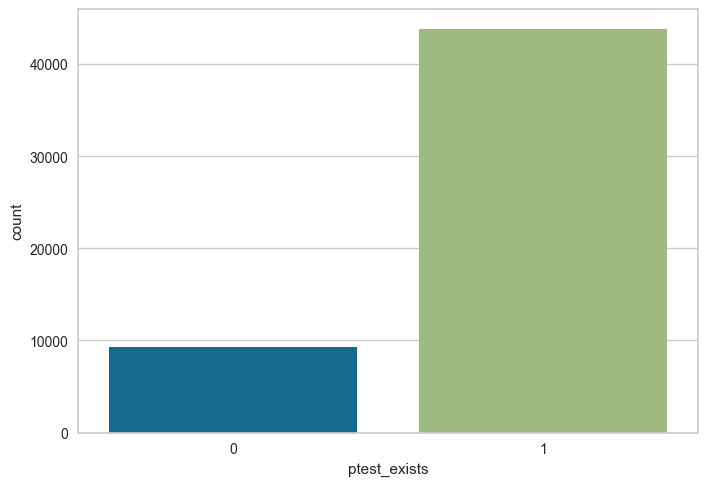

In [13]:
# view counts for categorical variables by changing the x variable
sns.countplot(x = 'ptest_exists', data = data_train)

In [21]:
data_train.describe()

,GPA at start of term,Retained,new_student,ptest_exists,aleks,sat_english,sat_math,act_composite,cccrtw,count_tests,...,Ever Early College,Athletic Indicator,Pell Eligibility Status,Gateway/Bridge status,aleks_scaled,sat_english_scaled,sat_math_scaled,act_composite_scaled,cccrtw_scaled,max_placement_score
count,45576.000000,53058.000000,53058.000000,53058.000000,37546.000000,8355.000000,8279.000000,4694.000000,31291.000000,53058.000000,...,53058.000000,53058.000000,53058.000000,53058.000000,37546.000000,8355.000000,8279.000000,4694.000000,31291.000000,43781.000000
mean,2.789945,0.611519,0.123148,0.825154,43.448330,502.793537,495.468052,18.546229,4.657007,2.199159,...,0.110766,0.008274,0.526009,0.000226,-0.032399,-0.038780,-0.027000,-0.003227,-0.015994,0.453210
std,0.849169,0.487409,0.328610,0.379839,22.603128,83.942819,88.327840,3.989798,1.443357,1.641851,...,0.313845,0.090585,0.499328,0.015037,0.998672,0.995512,0.993319,0.983939,1.001224,0.885531
min,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000,200.000000,8.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.952074,-3.629730,-3.349781,-2.604072,-3.246454,-3.246454
25%,2.330000,0.000000,0.000000,1.000000,27.000000,440.000000,430.000000,16.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,-0.759135,-0.783474,-0.763242,-0.631162,-1.165422,-0.008025
50%,2.900000,1.000000,0.000000,1.000000,41.000000,500.000000,500.000000,18.000000,5.000000,2.000000,...,0.000000,0.000000,1.000000,0.000000,-0.140574,-0.071909,0.023966,-0.137935,0.221933,0.654719
75%,3.400000,1.000000,0.000000,1.000000,61.000000,560.000000,550.000000,21.000000,6.000000,3.000000,...,0.000000,0.000000,1.000000,0.000000,0.743085,0.639655,0.586257,0.601906,0.915610,0.915610
max,4.000000,1.000000,1.000000,1.000000,100.000000,790.000000,800.000000,35.000000,6.000000,14.000000,...,1.000000,1.000000,1.000000,1.000000,2.466219,3.367318,3.397712,4.054497,0.915610,4.054497


In [9]:
# see which variables might show large variation between retained/not retained
data_train.groupby('Retained').mean()

,GPA at start of term,new_student,ptest_exists,aleks,sat_english,sat_math,act_composite,cccrtw,count_tests,test_waiver,HC_DA,HC_KK,HC_MX,HC_OH,HC_TR,HC_WR,HC_other,First_reg,Gender_Male,Gender_Unknown,age,Eth_Black,Eth_Asian,Eth_White,Eth_Other,Star Status,Deg_cert,Deg_terminal,FT,Ever Early College,Athletic Indicator,Pell Eligibility Status,Gateway/Bridge status,aleks_scaled,sat_english_scaled,sat_math_scaled,act_composite_scaled,cccrtw_scaled,max_placement_score
Retained,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.576190,0.147729,0.796090,41.413148,496.986947,487.652428,18.627814,4.57860,2.061712,0.080245,0.100233,0.070008,0.233359,0.063555,0.099457,0.199010,0.0,-34.308510,0.409955,0.001844,25.023384,0.325830,0.049971,0.114593,0.033961,0.109257,0.047157,0.341500,0.358820,0.097225,0.009606,0.519794,0.00000,-0.122320,-0.107642,-0.114893,0.016893,-0.070383,0.384305
1,2.918078,0.107533,0.843617,44.657722,505.654815,499.332130,18.485714,4.70474,2.286476,0.072089,0.090951,0.046046,0.247920,0.041977,0.112063,0.232602,0.0,-40.396844,0.361493,0.001633,24.703477,0.263761,0.067928,0.121278,0.029125,0.182611,0.032053,0.352617,0.470043,0.119368,0.007428,0.529957,0.00037,0.021035,-0.004847,0.016455,-0.018151,0.017118,0.494517


<Axes: >

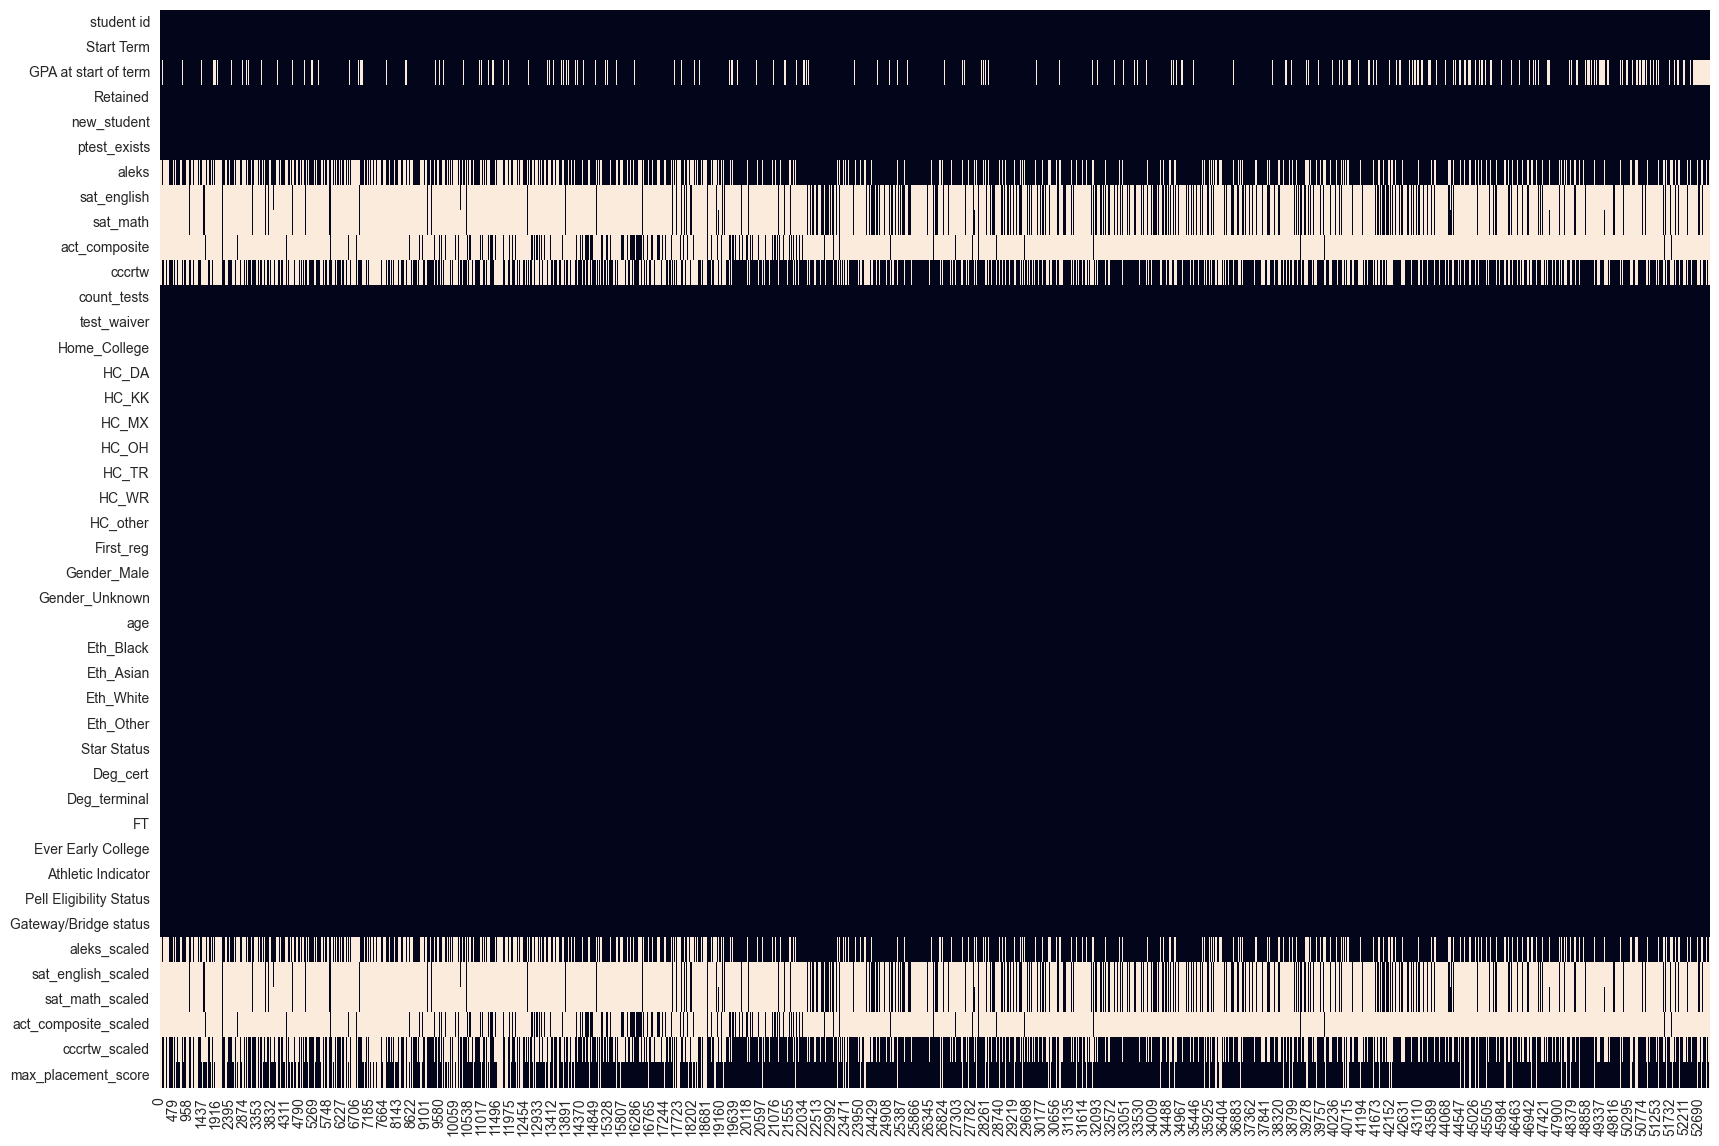

In [10]:
# check for null values
plt.figure(figsize=(20,14))
sns.heatmap(data_train.isnull().T, cbar = False)

<Axes: xlabel='Retained', ylabel='count'>

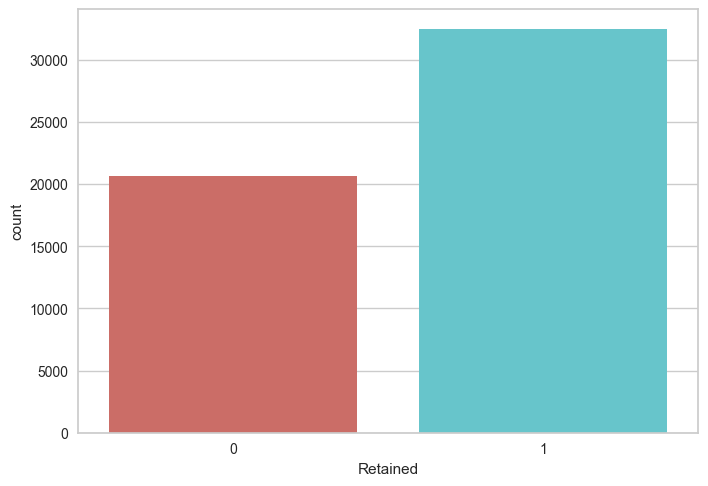

In [11]:
# Visualize retained/not retained 
sns.countplot(x='Retained',data=data_train, palette='hls')

<Axes: xlabel='count_tests', ylabel='Count'>

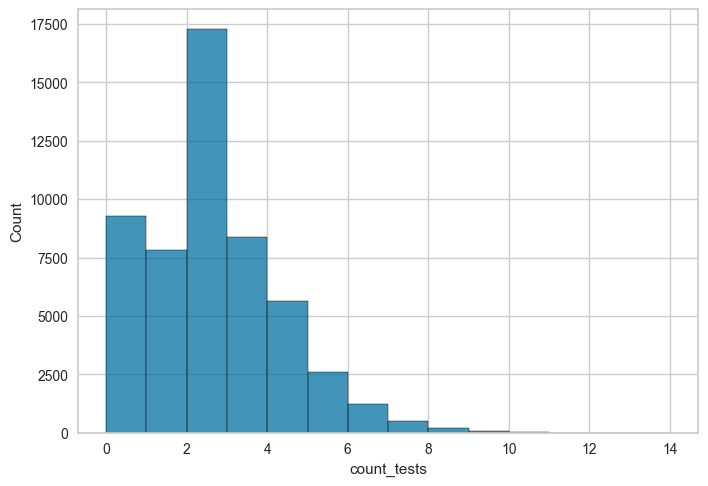

In [12]:
# view distribution for different numeric variables by changing the x variable
sns.histplot(data = data_train, x='count_tests', binwidth = 1)

<Axes: >

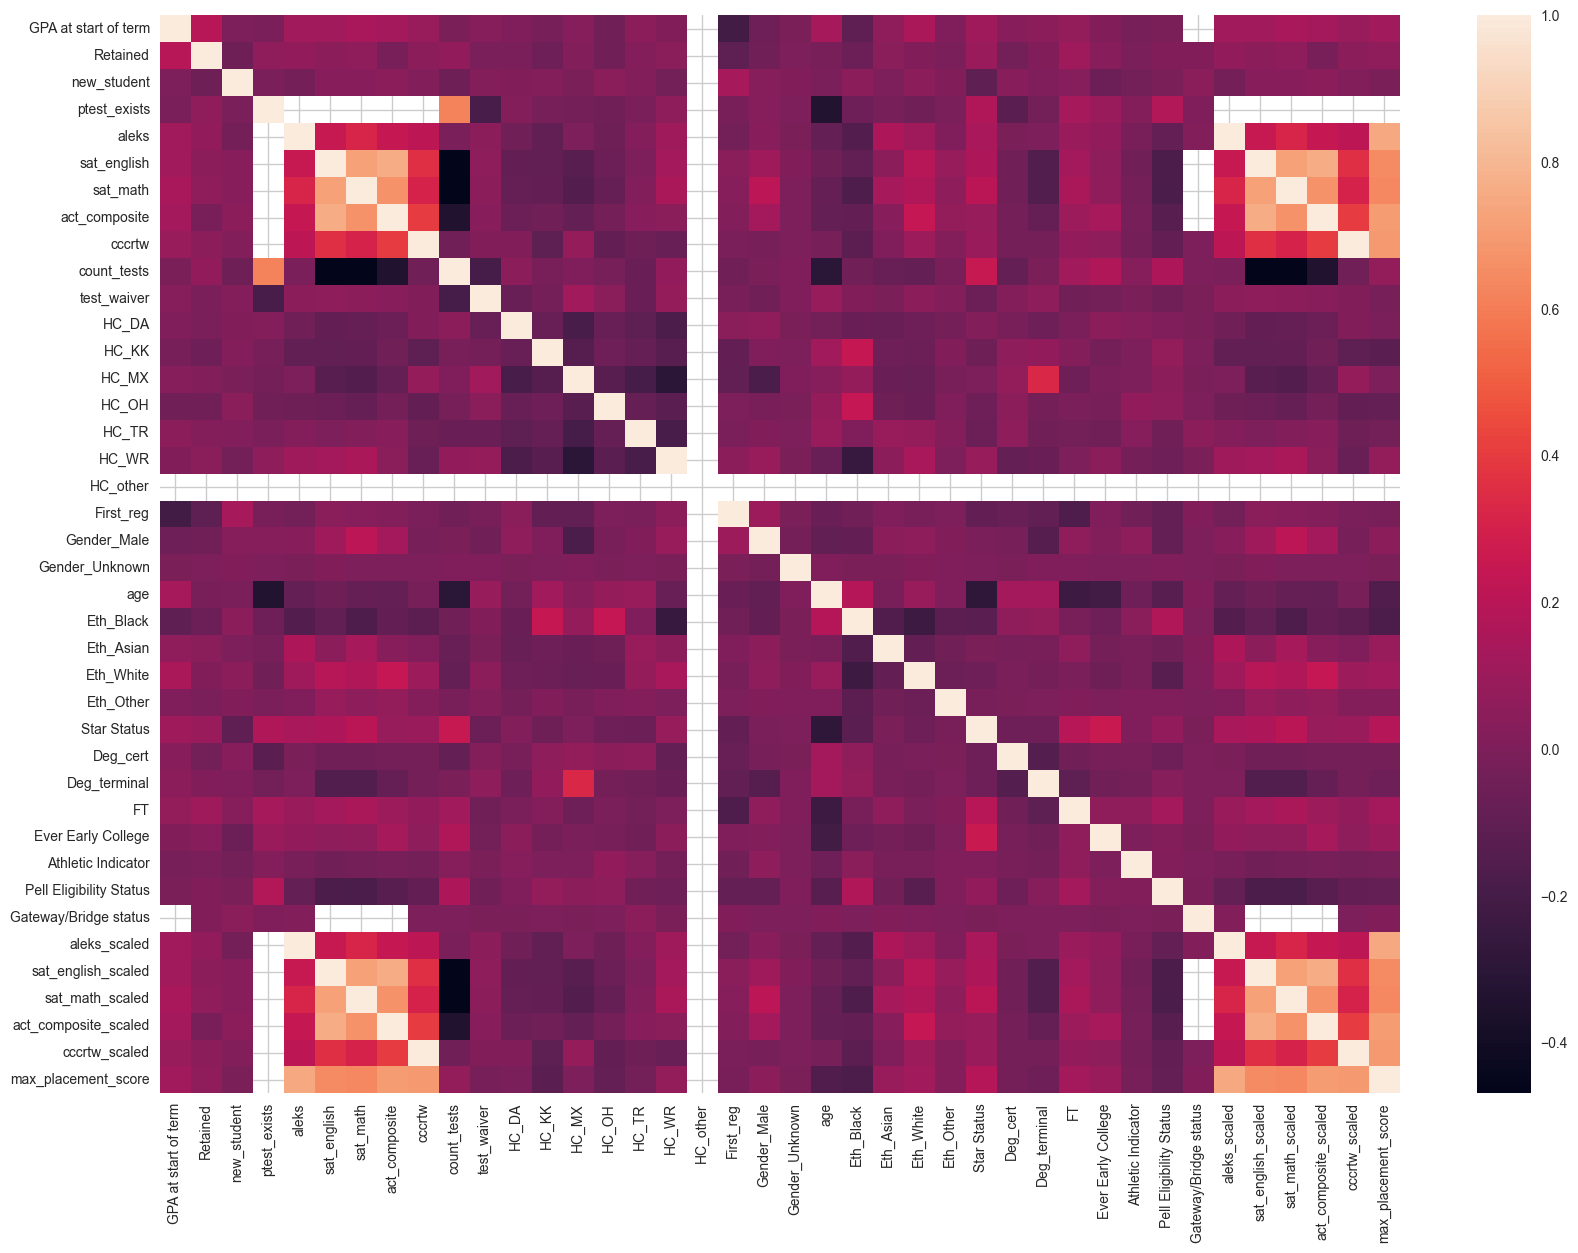

In [14]:
# Visualize correlations between data
plt.figure(figsize=(20,14))
sns.heatmap(data_train.corr())

<a id='modeling'></a>

# Modeling
[Top](#top)<br>

In [2]:
# bring in training data snapshot
data_train = pd.read_csv(r'C:\Users\Declan\Coding Projects\retention_model\2023SP\evaluation_data\data_train_2023-02-03.csv',index_col=0)
data_train.head()

,student id,Start Term,GPA Institutional Cumulative,Retained,new_student,ptest_exists,aleks,sat_english,sat_math,act_composite,...,Ever Early College,Athletic Indicator,Pell Eligibility Status,Gateway/Bridge status,aleks_scaled,sat_english_scaled,sat_math_scaled,act_composite_scaled,cccrtw_scaled,max_placement_score
0,4642,2021SP,3.18,0,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,5181,2020SP,3.09,0,0,1,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,-0.471087,-0.471087
2,5584,2022SP,2.23,0,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,7726,2020SP,4.00,0,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,8994,2021SP,2.58,1,0,0,NaN,NaN,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Notes on pycaret classification modeling:
# data split into train/test set
# numeric/categorical features inferred (should have been correctly set up by SQL query)
# 10 fold cross validation used
# numeric imputation done using mean value, categorical done using mode

classification_setup = classification.setup(data = data_train
                                            , target='Retained'
                                            , ignore_features = ['student id', 'Start Term', 'aleks', 'sat_english', 'sat_math', 'act_composite', 'cccrtw', 'aleks_scaled'
                                            , 'sat_english_scaled', 'sat_math_scaled', 'act_composite_scaled', 'cccrtw_scaled', 'Gateway/Bridge status', 'Home_College']
                                            , numeric_features = ['count_tests'], normalize = True, session_id = 1
                                           )

In [7]:
# view transformed data if desired
get_config("X")

,GPA Institutional Cumulative,new_student,ptest_exists,count_tests,test_waiver,HC_DA,HC_KK,HC_MX,HC_OH,HC_TR,...,Eth_White,Eth_Other,Star Status,Deg_cert,Deg_terminal,FT,Ever Early College,Athletic Indicator,Pell Eligibility Status,max_placement_score
42367,2.90,1,1,2,0,0,0,1,0,0,...,0,0,0,0,1,1,1,0,0,-0.581835
44083,1.83,0,1,2,0,0,0,1,0,0,...,0,0,1,0,1,1,0,0,1,0.434015
37742,3.37,1,1,2,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,1.317363
7491,2.94,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,NaN
30913,3.20,0,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.916478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40204,2.26,0,1,2,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0.916478
53045,3.33,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,NaN
39197,3.22,0,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0.831522
36272,3.18,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,NaN


In [8]:
# tests different sklearn classification models to determine high performers
best = classification.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:49:49
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [9]:
tuned_model = tune_model(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:50:45
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6820,0.7090,0.9049,0.6805,0.7768,0.2608,0.2953
1,0.6799,0.6967,0.9066,0.6782,0.7760,0.2541,0.2897
2,0.6901,0.7142,0.9133,0.6849,0.7828,0.2788,0.3167
3,0.6702,0.6905,0.8965,0.6728,0.7687,0.2326,0.2640
4,0.6726,0.6906,0.8904,0.6765,0.7688,0.2422,0.2708
5,0.6788,0.7025,0.8956,0.6803,0.7732,0.2564,0.2868
6,0.6721,0.6938,0.8961,0.6745,0.7697,0.2380,0.2691
7,0.6723,0.6909,0.8824,0.6784,0.7671,0.2452,0.2707
8,0.6683,0.6896,0.8921,0.6724,0.7668,0.2297,0.2592


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [10]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [39]:
# create final model to be used on current term data, as well as evaluation plots of training data for comparison to current term data after the term ends
final_model = finalize_model(tuned_model)
save_model(final_model, 'sp23_retention_model_TODAYSDATE')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['student id',
                                                        'Start Term', 'aleks',
                                                        'sat_english',
                                                        'sat_math',
                                                        'act_composite',
                                                        'cccrtw', 'aleks_scaled',
                                                        'sat_english_scaled',
                                                        'sat_math_scaled',
                                                        'act_composite_scaled',
                                                        'cccrtw_scaled',
                                                        'Gateway/Bridge statu

In [431]:
# save plots for later evaluation - 
plot_model(final_model, plot = 'calibration', save = True) # save calibration curve
plot_model(final_model, plot = 'confusion_matrix', save = True) # save confusion matrix

# move the files to the evaluation folder
foldername = r'C:\Users\dmcdonnell2\OneDrive - City Colleges of Chicago\Python Projects\git\retention_model\2023SP\evaluation_data'
conmatrixfile = r'Confusion Matrix.png'
calibrationfile = r'Calibration Curve.png'
os.rename(conmatrixfile, os.path.join(foldername, conmatrixfile))
os.rename(calibrationfile, os.path.join(foldername, calibrationfile))

# rename the files
os.rename(os.path.join(foldername, conmatrixfile), os.path.join(foldername, 'confusion_matrix_TODAYSDATE.png'))
os.rename(os.path.join(foldername, calibrationfile), os.path.join(foldername, 'calibration_curve_TODAYSDATE.png'))

<a id='eval'></a>

# Evaluation of Training vs Production outcomes
##### Compares training data evaluation metrics to current term predictions. To be run once current term retention numbers start posting
- [Evaluation metrics (Accuracy, AUC, precision/recall)](#eval_metrics)
- [Confusion Matrix](#confusion)
- [Calibration curve of test v actual](#calibration)
- [Brier score of test v actual](#brier) <br>

[Top](#top)

In [16]:
# model used for training
# THIS WILL NOT WORK ON PRIOR MODELS - THEY WERE CREATED WITH OLDER VERSION OF PYCARET. IT WILL WORK MOVING FORWARD
# final_model = load_model('sp23_retention_model_20230203')

# load data that was used to train the model to get evaluation metrics
data_train_snapshot = pd.read_csv(r'C:\Users\dmcdonnell2\OneDrive - City Colleges of Chicago\Python Projects\git\retention_model\2023SP\evaluation_data\data_train_2023-02-03.csv',index_col=0)

# load data that was fed into the final model and used to tier students at the start of the current term
current_term_eval_set = pd.read_csv(r'C:\Users\dmcdonnell2\OneDrive - City Colleges of Chicago\Python Projects\git\retention_model\2023SP\evaluation_data\current_term_eval_snapshot_2023-02-03.csv',index_col=0)

# re-run retention query to get retention actuals
# df = pd.read_sql_query(retention_query.read(),conn)
df['student id'] = df['student id'].astype(int)

# simulate retention actuals with below code
df['Retained'] = np.random.choice([0,1], size=len(df), p = [.4, .6]) # change p for simulated retention outputs. p = [.4, .6] means 40% chance of not retained, 60% chance of retained

# merge retention actuals into snapshot from start of the term that got predicted retention scores
ret_actuals = pd.merge(current_term_eval_set, df[['student id', 'Start Term', 'Retained']], how = 'left', on = ['student id', 'Start Term'], suffixes = ['_old', ''])
ret_actuals['Retained'] = ret_actuals['Retained'].fillna(0)
ret_actuals['Retained'] = ret_actuals['Retained'].astype(int)

# get dataframe for model predictions
ret_actuals_model = ret_actuals.drop(['Retained_old', 'Label', 'Score_0', 'Score_1', 'hc_percentile', 'tier'], axis=1)


AttributeError: module 'pycaret.internal.preprocess' has no attribute 'DataTypes_Auto_infer'

##### Evaluation metrics (Accuracy, AUC, precision/recall) <a id='eval_metrics'></a>

In [30]:
# Training data metrics using snapshot and final model
training_metrics = predict_model(final_model, raw_score = True, data = data_train_snapshot)

# Current term data using predicted vs. actual retention rates
current_set = predict_model(final_model, raw_score = True, data = ret_actuals_model)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7142,0.7667,0.8682,0.7212,0.7879,0.3611,0.3760


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.5281,0.5136,0.6101,0.5929,0.6014,0.0234,0.0235


##### Confusion Matrix <a id='confusion'></a> <br>

##### Training set
![title](evaluation_data/confusion_matrix_2023-02-03.png)

##### Current term data

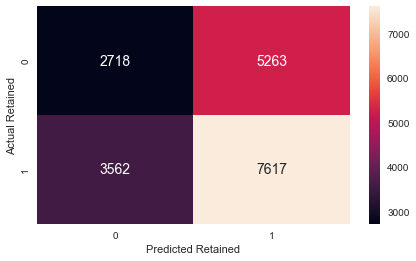

In [31]:
plt.figure(figsize=(7, 4))
sns.heatmap(pd.crosstab(ret_actuals['Retained'], ret_actuals['Label']), annot = True, fmt ='0')
plt.xlabel('Predicted Retained')
plt.ylabel('Actual Retained')
plt.show()


##### Calibration curve <a id='calibration'></a>


##### Training set
![title](evaluation_data/calibration_curve_2023-02-03.png)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


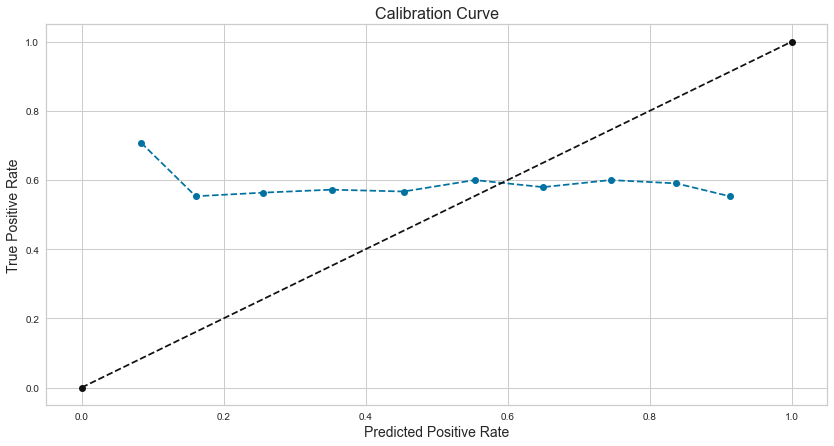

In [32]:
# First, sort the dataframe by the 'Score' column
ret_actuals.sort_values(by='Score_1', inplace=True)

# Create bins of equal size
bins = np.linspace(0, 1, 11)# min(ret_actuals['Score_1']), max(ret_actuals['Score_1']), 10)

# Create a new column for the binned scores
ret_actuals['Score_Binned'] = pd.cut(ret_actuals['Score_1'], bins)

# Calculate the average score for each bin
bin_avg = ret_actuals.groupby('Score_Binned').mean()['Retained']
bin_avg_predicted = ret_actuals.groupby('Score_Binned').mean()['Score_1']

# create figure
plt.figure(figsize=(14,7))

# Plot calibration curve
plt.plot(bin_avg_predicted, bin_avg, marker='o', linestyle='--', color='b')

# Plot reference line
plt.plot([0, 1], [0, 1], marker='o', linestyle='--', color='k')

# Add labels
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('Predicted Positive Rate', fontsize=14)

# Add title
plt.title('Calibration Curve', fontsize=16)

# Add legend
plt.legend(loc="lower right", fontsize=14)

plt.show()

##### Brier score <a id='brier'></a>

In [33]:
# calculate brier score on training set (compares retention rate to predicted retention rate in training set)
brier_score_train = brier_score_loss(training_metrics['Retained'], training_metrics['Score_1'])

# calculate reference brier score on training set (compares retention rate to reference rate in training set)
training_metrics['Retained_reference_rate'] = .61 # manually adjust this value to equal the average retention rate in the training set, typically 60-75%
brier_score_train_ref = brier_score_loss(training_metrics['Retained'], training_metrics['Retained_reference_rate'])

# calculate brier skill score on training set (compares brier score train to brier score train ref to see if model is more skilled than simply imputing average retention rate)
bss_train = 1 - (brier_score_train / brier_score_train_ref)

print('Training data - brier score = ', round(brier_score_train, 3))
print('Training data - brier score reference (', training_metrics['Retained_reference_rate'][0]*100, '% reference retention rate) = ', round(brier_score_train_ref, 3), sep = '')
print('Training data - brier skill score = ', round(bss_train, 3))


Training data - brier score =  0.189
Training data - brier score reference (61.0% reference retention rate) = 0.238
Training data - brier skill score =  0.205


In [34]:
# calculate brier score on current term data (compares retention rate to predicted retention rate for current term)
brier_score_actual = brier_score_loss(ret_actuals['Retained'], ret_actuals['Score_1'])

# calculate reference brier score on training set (compares retention rate to reference rate in training set)
ret_actuals['Retained_reference_rate'] = .61 # manually adjust this value to equal the average retention rate in the training set, typically 60-75%
brier_score_actual_ref = brier_score_loss(ret_actuals['Retained'], ret_actuals['Retained_reference_rate'])

# calculate brier skill score on training set (compares brier score train to brier score train ref to see if model is more skilled than simply imputing average retention rate)
bss_actual = 1 - (brier_score_actual / brier_score_actual_ref)

print('Current term data - brier score = ', round(brier_score_actual, 3))
print('Current term data - brier score reference (', ret_actuals['Retained_reference_rate'][0]*100, '% reference retention rate) = ', round(brier_score_actual_ref, 3), sep = '')
print('Current term data - brier skill score = ', round(bss_actual, 3))

Current term data - brier score =  0.272
Current term data - brier score reference (61.0% reference retention rate) = 0.244
Current term data - brier skill score =  -0.115
